In [6]:
import pandas as pd
from glob import glob
import sys
import os
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(project_root)

from utils.functions import filter_similar_atmospheric_conditions

In [11]:


all_files = glob("../unprocessed_data/*Gui.parquet")
print(all_files)

s1a2020 = pd.read_parquet(all_files[0])
s1a2021 = pd.read_parquet(all_files[1])
s1b2020 = pd.read_parquet(all_files[2])
s1b2021 = pd.read_parquet(all_files[3])

print(len(s1a2020), len(s1a2021), len(s1b2020), len(s1b2021))

['../unprocessed_data\\S1A_2020_4_Gui.parquet', '../unprocessed_data\\S1A_2021_4_Gui.parquet', '../unprocessed_data\\S1B_2020_4_Gui.parquet', '../unprocessed_data\\S1B_2021_4_Gui.parquet']
720678 685889 736103 709018


In [12]:
def convert_L_to_log(row):
    if row > 0:
        return np.log(row)
    else:
        return - np.log(-row)

In [13]:
s1a2020['L_log'] = s1a2020['L'].apply(lambda x: convert_L_to_log(x))
s1a2021['L_log'] = s1a2021['L'].apply(lambda x: convert_L_to_log(x))
s1b2020['L_log'] = s1b2020['L'].apply(lambda x: convert_L_to_log(x))
s1b2021['L_log'] = s1b2021['L'].apply(lambda x: convert_L_to_log(x))

In [14]:
def remove_sea_ice(df):
    df = df[df["class_1"] != "SI"]
    df = df[df["class_2"] != "SI"]
    df = df[df["class_3"] != "SI"]

    return df

s1a2020 = remove_sea_ice(s1a2020)
s1a2021 = remove_sea_ice(s1a2021)
s1b2020 = remove_sea_ice(s1b2020)
s1b2021 = remove_sea_ice(s1b2021)





In [15]:
wspd_bin = (5, 15)
L_bin = (-10e9, -0.1)

s1a2020_unstable = filter_similar_atmospheric_conditions(s1a2020, wspd_range=wspd_bin, L_range=L_bin)
s1a2021_unstable = filter_similar_atmospheric_conditions(s1a2021, wspd_range=wspd_bin, L_range=L_bin)

s1b2020_unstable = filter_similar_atmospheric_conditions(s1b2020, wspd_range=wspd_bin, L_range=L_bin)
s1b2021_unstable = filter_similar_atmospheric_conditions(s1b2021, wspd_range=wspd_bin, L_range=L_bin)

print(len(s1a2020_unstable) + len(s1a2021_unstable) + len(s1b2020_unstable) + len(s1b2021_unstable))


1656897


In [16]:
L_bin = (0.1, 10e9)

s1a2020_stable = filter_similar_atmospheric_conditions(s1a2020, wspd_range=wspd_bin, L_range=L_bin)
s1a2021_stable = filter_similar_atmospheric_conditions(s1a2021, wspd_range=wspd_bin, L_range=L_bin)
s1b2020_stable = filter_similar_atmospheric_conditions(s1b2020, wspd_range=wspd_bin, L_range=L_bin)
s1b2021_stable = filter_similar_atmospheric_conditions(s1b2021, wspd_range=wspd_bin, L_range=L_bin)

print(len(s1a2020_stable) + len(s1a2021_stable) + len(s1b2020_stable) + len(s1b2021_stable))


336922


In [17]:
def plot_comparative_boxplots(dfs, stable, cols_to_plot):
    """
    Plot boxplots for selected columns across 4 DataFrames for comparison.

    Parameters:
    - dfs: list of 4 DataFrames
    - stable: bool, whether the data is stable (used in title)
    - cols_to_plot: list of column names to plot
    """
    fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(6 * len(cols_to_plot), 6), sharey=False)
    if len(cols_to_plot) == 1:
        axes = [axes]

    for ax, col in zip(axes, cols_to_plot):
        data = [df[col].dropna() for df in dfs]
        
        data = [remove_outliers(d) for d in data]
        for d in data:
            print(col, len(d))

        ax.boxplot(data, tick_labels=[f'DF{i+1}' for i in range(4)])
        ax.set_title(col)
        ax.grid(True)

    state = 'Stable' if stable else 'Unstable'
    fig.suptitle(f'{state} - Comparative Boxplots', fontsize=16)
    plt.tight_layout()
    plt.show()

def remove_outliers(series):
    """
    Remove outliers from a Series using the IQR method.

    Parameters:
    - series: pd.Series

    Returns:
    - pd.Series without outliers
    """
    q1 = series.quantile(0.05)
    q3 = series.quantile(0.95)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series[(series >= lower) & (series <= upper)]



wspd 85671
wspd 81057
wspd 87664
wspd 82530
L_log 85658
L_log 81044
L_log 87652
L_log 82518
airt 85671
airt 81057
airt 87664
airt 82530
sst 85671
sst 81057
sst 87664
sst 82530


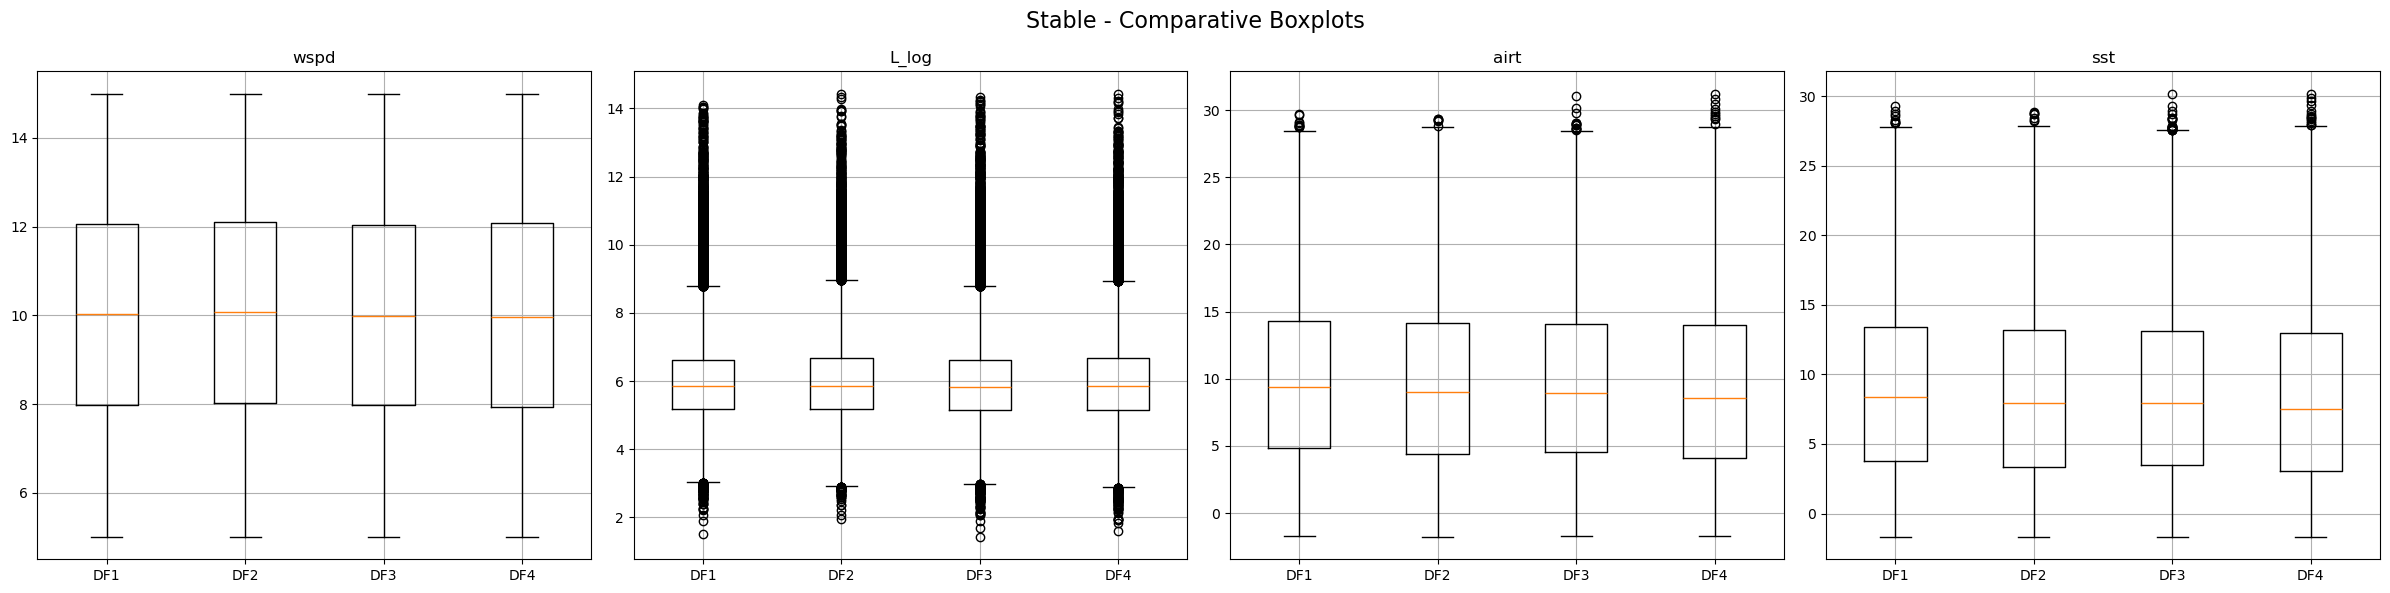

In [18]:
plot_comparative_boxplots([s1a2020_stable, s1a2021_stable, s1b2020_stable, s1b2021_stable], stable=True, cols_to_plot=['wspd', 'L_log', 'airt', 'sst'])

wspd 415813
wspd 406942
wspd 425186
wspd 408956
L_log 415723
L_log 406863
L_log 425110
L_log 408877
airt 415813
airt 406942
airt 425186
airt 408956
sst 415813
sst 406942
sst 425186
sst 408956


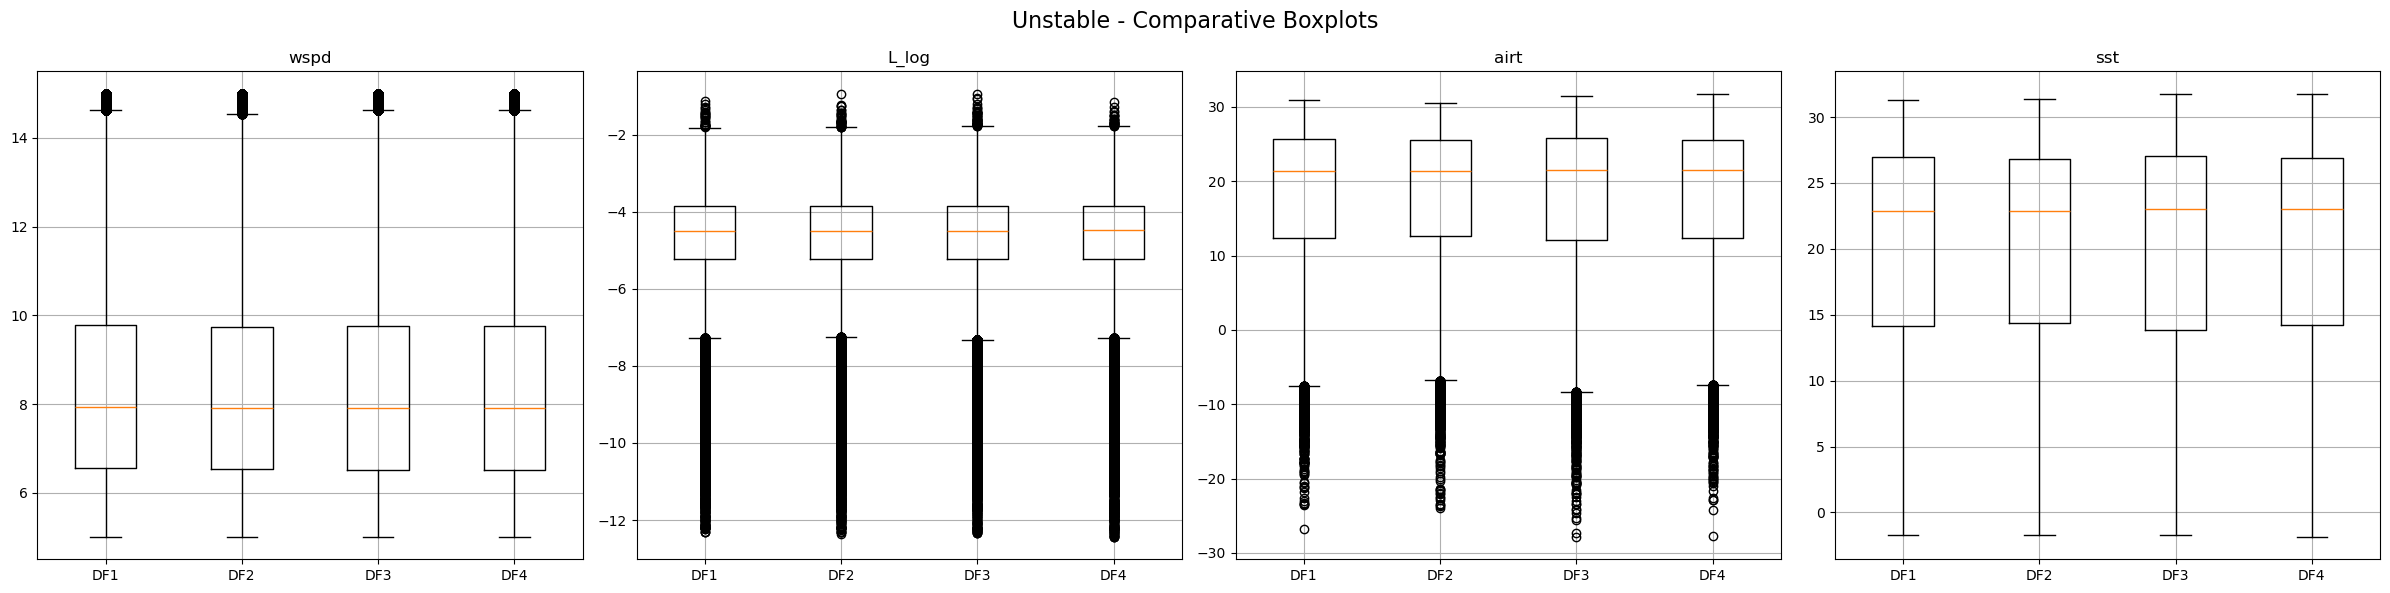

In [19]:
plot_comparative_boxplots([s1a2020_unstable, s1a2021_unstable, s1b2020_unstable, s1b2021_unstable], stable=False, cols_to_plot=['wspd', 'L_log', 'airt', 'sst'])

In [20]:
s1a2020_unstable_sample = s1a2020_unstable.sample(50000)
s1a2021_unstable_sample = s1a2021_unstable.sample(50000)
s1b2020_unstable_sample = s1b2020_unstable.sample(50000)
s1b2021_unstable_sample = s1b2021_unstable.sample(50000)

s1a2020_stable_sample = s1a2020_stable.sample(50000)
s1a2021_stable_sample = s1a2021_stable.sample(50000)
s1b2020_stable_sample = s1b2020_stable.sample(50000)
s1b2021_stable_sample = s1b2021_stable.sample(50000)



In [22]:
s1a2020_unstable_sample.filename.to_frame().to_parquet("../unprocessed_data/s1a2020_unstable_sample.parquet")
s1a2021_unstable_sample.filename.to_frame().to_parquet("../unprocessed_data/s1a2021_unstable_sample.parquet")
s1b2020_unstable_sample.filename.to_frame().to_parquet("../unprocessed_data/s1b2020_unstable_sample.parquet")
s1b2021_unstable_sample.filename.to_frame().to_parquet("../unprocessed_data/s1b2021_unstable_sample.parquet")

s1a2020_stable_sample.filename.to_frame().to_parquet("../unprocessed_data/s1a2020_stable_sample.parquet")
s1a2021_stable_sample.filename.to_frame().to_parquet("../unprocessed_data/s1a2021_stable_sample.parquet")
s1b2020_stable_sample.filename.to_frame().to_parquet("../unprocessed_data/s1b2020_stable_sample.parquet")
s1b2021_stable_sample.filename.to_frame().to_parquet("../unprocessed_data/s1b2021_stable_sample.parquet")